<a href="https://colab.research.google.com/github/navavatpi/researchPhd/blob/developModeling/dataAcquisitionAndPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Acquisition & Data Preparation

## Environment Setup

In [ ]:
# Enabling and testing the TPU
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [ ]:
# libraries import
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV # I/O separator
from sklearn.preprocessing import StandardScaler # data preparation
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# %matplotlib inline # enable visualization visible
random_seed = 20 # random seed

In [ ]:
# connect to google drive to obtain dataset
# !note: need to perform authorization by following below link
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Acquisition

In [ ]:
# list all data sample in specific directory
!ls /content/drive/My\ Drive/all_about_phd/phd_data/sample_data

corriander_sample01_0001_emptyname		    corriander_sample_2_0009
corriander_sample01_defect_emptyname_0001	    corriander_sample_2_0010
corriander_sample01__emptyname_0001		    corriander_sample_3_0001
corriander_sample01_emptyname_0002		    corriander_sample_3_0002
corriander_sample01__emptyname_2021-02-18_06-49-42  corriander_sample_3_0003
corriander_sample01__emptyname_2021-02-18_07-17-28  corriander_sample_3_0005
corriander_sample01__emptyname_2021-02-18_07-30-45  corriander_sample_3_0006
corriander_sample01__emptyname_2021-02-18_08-13-22  corriander_sample_3_0007
corriander_sample_2_0001			    corriander_sample_3_0008
corriander_sample_2_0006			    corriander_sample_3_0009
corriander_sample_2_0007			    corriander_sample_3_0010
corriander_sample_2_0008


In [ ]:
# define path to files
defaultdir = '/content/drive/My Drive/all_about_phd/'

## full dataset
# rootdir = defaultdir + 'data_20210218'

## test dataset
rootdir = defaultdir + 'phd_data/sample_data'

## check
print(rootdir)

/content/drive/My Drive/all_about_phd/phd_data/sample_data


In [ ]:
# define dataset & metadata as label function
def read_data_from_files(path=rootdir):
  ## assign dataset & metadata
  X_raw = []
  y_slug= []

  ## iterate through directory
  for subdir, dirs, files in os.walk(rootdir):
      for file in files:
        # filter only for raw file
        if file.endswith('.raw'):
            # assign data -> dataset 
            ## by fixing dimension as follows HSI e.g. 
            ### X = length (collection time dependent),
            ### Y = spectral domain (fixed at 224, all spectra),
            ### Z = width (fixed at 640)
            ### then swap axes between width (Z) vs. spectral (Y)
            X_raw.append(np.fromfile(os.path.join(subdir, file), dtype='uint16').reshape(-1,224,640).swapaxes(1,2))
            
            # assign label -> cut some unneceasary
            y_slug.append(re.search('(\d+.+\d+)', file).group(0))

  # extract label; y <- data_slug using RegEx
  y = np.stack([(int(re.findall('([\d{1}])(?=_)', y_slug[index], flags=0)[0])) for index, _ in enumerate(y_slug)])

  # different class number from label 
  y = to_categorical(y - 1, num_classes=len(list(set(y))))

  del y_slug

  # output type = list (x), array (y)
  return X_raw, y

In [ ]:
# aquire dataset using defined function
# !note: this process take some minutes
X_raw, y = read_data_from_files()

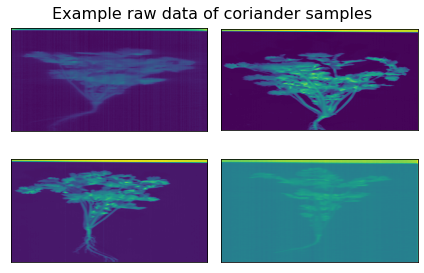

In [ ]:
# show images of sample in a spectrum
fig, axes = plt.subplots(nrows=2, ncols=2)

## sample 0th - 3th are selected
## Z; spectral, is randomly specified
axes[0, 0].imshow(X_raw[0][:,:,0])
axes[0, 1].imshow(X_raw[1][:,:,50])
axes[1, 0].imshow(X_raw[2][:,:,100])
axes[1, 1].imshow(X_raw[3][:,:,223])

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
fig.suptitle('Example raw data of coriander samples', fontsize=16)
fig.tight_layout()

In [ ]:
# # disconnect google drive after finish

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


## Data Prepatation

In [ ]:
# define shorten all sample length into the shortest length function
def shorten_data(X_raw=X_raw):
  # find minimum raw data length
  length_min = np.amin([X_raw[index].shape[0] for index, _ in enumerate(X_raw)])

  # find minimum raw data length index
  length_min_index = [index for index, _ in enumerate(X_raw) if X_raw[index].shape[0] == length_min][0]

  # filter raw data length to equal to minimum sample length
  X_shorten = np.stack([X_raw[index][:length_min] for index, _ in enumerate(X_raw)], axis=0)

  # output type = array
  return X_shorten

In [ ]:
# perform shortening function
X = shorten_data(X_raw=X_raw)

# checkout dimensionality of shorten data
print('data dimensionality was shorten from', X_raw[0].shape, 'into', X[0].shape)

# delete unused data
del X_raw

data dimensionality was shorten from (337, 640, 224) into (330, 640, 224)


In [ ]:
# define scaler function to adjust value using Z-score scaling
def data_scaler(X=X):

  # setup empty variable w/ the same shape to original tensor
  X_scaled = np.zeros_like(X)

  # scale along spectral domain
  for wavelength in range(X.shape[-1]):
      
      # define scaler method
      scaler = StandardScaler(with_mean=False) # specify to not centering data when dealing w/ sparse matrix
      
      # perform normalization -> assign to a temporary variable by
          # flatten all data points shape
          # standardize
          # reshape back to orignial shape
      X_scaled[:,:,:,wavelength] = scaler.fit_transform(X[:,:,:,wavelength].ravel().reshape(-1,1)).reshape(X[:,:,:,1].shape)
  
  return X_scaled

In [ ]:
# perform scaler function
# !note: this process take some minutes
X = data_scaler(X=X)

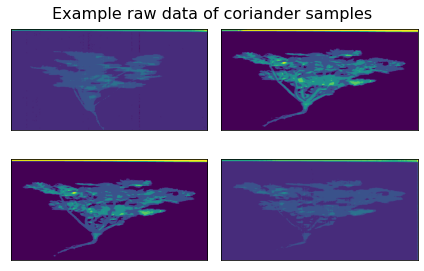

In [ ]:
# show images of scaled data
fig, axes = plt.subplots(nrows=2, ncols=2)

## sample 0th - 3th are selected
## Z; spectral, is randomly specified
axes[0, 0].imshow(X[20][:,:,0])
axes[0, 1].imshow(X[0][:,:,50])
axes[1, 0].imshow(X[0][:,:,100])
axes[1, 1].imshow(X[0][:,:,223])

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
fig.suptitle('Example raw data of coriander samples', fontsize=16)
fig.tight_layout()

In [ ]:
# Assign by splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

# see splitted data
print('train input: ', len(X_train), '\t train label: ', len(y_train))
print('test input: ', len(X_test), '\t\t test label: ', len(y_test))

train input:  17 	 train label:  17
test input:  6 		 test label:  6


In [ ]:
# save processed datas into drive
np.save(defaultdir + '/processed_data/X_train', X_train)
np.save(defaultdir + '/processed_data/X_test', X_test)
np.save(defaultdir + '/processed_data/y_train', y_train)
np.save(defaultdir + '/processed_data/y_test', y_test)